# ResNet

In [2]:
!nvidia-smi

Sun Oct 31 00:17:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## import

In [3]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.keras.utils import to_categorical
import pandas as pd

## データ

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
x_train = pd.read_csv('/content/drive/MyDrive/reversi/dataset/train_boards.csv', index_col=0, header=0)
x_test = pd.read_csv('/content/drive/MyDrive/reversi/dataset/test_boards.csv', index_col=0, header=0)
y_train = pd.read_csv('/content/drive/MyDrive/reversi/dataset/train_labels.csv', index_col=0, header=0)
y_test = pd.read_csv('/content/drive/MyDrive/reversi/dataset/test_labels.csv', index_col=0, header=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

In [8]:
#cnn用に画像データの形式に入力を変換
x_train = x_train.reshape((-1, 8, 8, 1))
x_test = x_test.reshape((-1, 8, 8, 1))

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
print('x_train: {}, x_test: {},\ny_train: {}, y_test:{}'.format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

x_train: (1029887, 8, 8, 1), x_test: (257472, 8, 8, 1),
y_train: (1029887, 64), y_test:(257472, 64)


## model

In [11]:
# 畳み込み層の生成
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False,
        kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [12]:
# 残差ブロックAの生成
def first_residual_unit(filters, strides):
    def f(x):
        # →BN→ReLU
        x = BatchNormalization()(x)
        b = Activation('relu')(x)

        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 1, strides)(b)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # 畳み込み層→
        x = conv(filters, 1)(x)

        # ショートカットのシェイプサイズを調整
        sc = conv(filters, 1, strides)(b)

        # Add
        return Add()([x, sc])
    return f

In [13]:
# 残差ブロックBの生成
def residual_unit(filters):
    def f(x):
        sc = x
        
        # →BN→ReLU
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→
        x = conv(filters, 1)(x)

        # Add
        return Add()([x, sc])
    return f

In [14]:
# 残差ブロックAと残差ブロックB x 17の生成
def residual_block(filters, strides, unit_size):
    def f(x):
        x = first_residual_unit(filters, strides)(x)
        for i in range(unit_size-1):
            x = residual_unit(filters)(x)
        return x
    return f

In [15]:
# 入力データのシェイプ
input = Input(shape=(8, 8, 1))

# 畳み込み層
x = conv(16, 3)(input)

# 残差ブロック x 54
x = residual_block(64, 1, 18)(x)
x = residual_block(128, 2, 18)(x)
x = residual_block(256, 2, 18)(x)

# →BN→ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# プーリング層
x = GlobalAveragePooling2D()(x)

# 全結合層
output = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# モデルの作成
model = Model(inputs=input, outputs=output)

In [16]:
# コンパイル
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

In [17]:
history = model.fit(x_train, y_train, batch_size=256, epochs=10, validation_split=0.1)

Epoch 1/10
3621/3621 [==============================] - 555s 140ms/step - loss: 5.3333 - accuracy: 0.2070 - val_loss: 4.7450 - val_accuracy: 0.2687
Epoch 2/10
3621/3621 [==============================] - 502s 139ms/step - loss: 4.3216 - accuracy: 0.3278 - val_loss: 3.9463 - val_accuracy: 0.3799
Epoch 3/10
3621/3621 [==============================] - 495s 137ms/step - loss: 3.6615 - accuracy: 0.4170 - val_loss: 3.4586 - val_accuracy: 0.4358
Epoch 4/10
3621/3621 [==============================] - 502s 139ms/step - loss: 3.2380 - accuracy: 0.4607 - val_loss: 3.1104 - val_accuracy: 0.4670
Epoch 5/10
3621/3621 [==============================] - 505s 139ms/step - loss: 2.9307 - accuracy: 0.4869 - val_loss: 2.8654 - val_accuracy: 0.4788
Epoch 6/10
3621/3621 [==============================] - 506s 140ms/step - loss: 2.6860 - accuracy: 0.5046 - val_loss: 2.6623 - val_accuracy: 0.4904
Epoch 7/10
3621/3621 [==============================] - 499s 138ms/step - loss: 2.4815 - accuracy: 0.5204 - val_

In [18]:
# モデルの保存
model.save('/content/drive/MyDrive/reversi/resnet_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


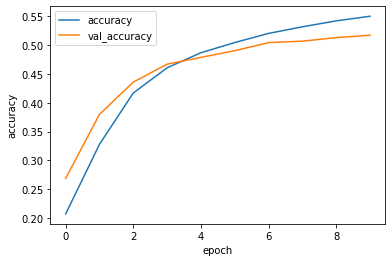

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('loss: {:.3f}, accuracy: {:.3f}'.format(test_loss, test_acc))

8046/8046 [==============================] - 247s 30ms/step - loss: 2.1154 - accuracy: 0.5154
loss: 2.115, accuracy: 0.515
